In [1]:
import opendatasets as od 
od.download('https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza')

Skipping, found downloaded files in ".\pizza-not-pizza" (use force=True to force download)


In [2]:
import torch.nn as nn
import re
import numpy as np
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms , datasets , models
import matplotlib.pyplot as plt
import time
import os
import torch
import torchvision
from PIL import Image


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:

batch_size = 64

train_transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4,0.4,0.4],[0.2,0.2,0.2])
    ])
test_transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.4,0.4,0.4],[0.2,0.2,0.2])
])


data_dir = 'pizza-not-pizza/pizza_not_pizza'
train_dataset = datasets.ImageFolder(data_dir,transform=train_transform)
# test_dataset = datasets.ImageFolder(data_dir+'/test',transform=test_transform)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
# test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
class_names = train_dataset.classes

In [4]:
print(class_names)
print(len(class_names))

['not_pizza', 'pizza']
2


torch.Size([3, 228, 1132])


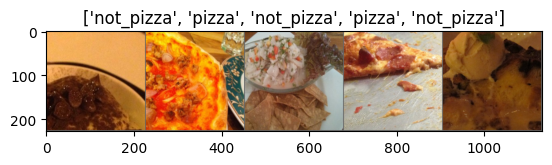

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4, 0.4, 0.4])
    std = np.array([0.2, 0.2, 0.2])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# * Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# * getting only 5 images 
inputs = inputs[:5]
classes = classes[:5]
# * Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)
imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model,criterion,optimizer , scheduler , num_epochs=25):
    since = time.time()
    for epoch in range(num_epochs):
        epoch_time_start = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        running_loss = 0
        running_corrects = 0
        i=1
        for input , labels in train_dataloader:
            print(f'iterations {i}/{len(train_dataloader)}',end='')
            input = input.to(device)
            labels = labels.to(device)

            output = model(input)
            _ , preds = torch.max(output,1)
            
            loss = criterion(output,labels)

            optimizer.zero_grad()

            loss.backward() 
            optimizer.step()
            running_loss += loss.item()*input.size(0)
            running_corrects += torch.sum(preds==labels.data)
            i+=1
            print('\r',end='')
        scheduler.step()
        print()
        epoch_loss = running_loss/len(train_dataset)
        epoch_acc = running_corrects.double()/len(train_dataset)
        print(f'Training loss: {epoch_loss}, acc: {epoch_acc}')
        epoch_time_end = time.time()
        print(f'Time taken for epoch: {epoch_time_end-epoch_time_start}')
    time_elapsed = time.time() - since
    print(f'Time Taken: {time_elapsed}')

    return model      

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

for params in model_ft.parameters():
    params.requires_grad = False

num_ftrs = model_ft.fc.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

512


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 1/5
--------------------
iterations 31/31
Training loss: 0.5654986713873649, acc: 0.7115971515768057
Time taken for epoch: 50.73532819747925
Epoch 2/5
--------------------
iterations 31/31
Training loss: 0.3607765602616788, acc: 0.8606307222787386
Time taken for epoch: 49.55178165435791
Epoch 3/5
--------------------
iterations 31/31
Training loss: 0.3115710487564607, acc: 0.8799593082400814
Time taken for epoch: 49.06729483604431
Epoch 4/5
--------------------
iterations 31/31
Training loss: 0.2840730720867582, acc: 0.8891149542217701
Time taken for epoch: 50.42956066131592
Epoch 5/5
--------------------
iterations 31/31
Training loss: 0.2695306242118653, acc: 0.8947100712105799
Time taken for epoch: 49.504175901412964
Time Taken: 249.28814125061035


In [9]:
torch.save(model_ft.state_dict(),'model.pth')

In [10]:
def visualize_model(model,images_paths):
    model.eval()
    for image in images_paths:
        img = Image.open(image)
        plt.imshow(img)
        img = train_transform(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        with torch.no_grad():
            out = model(img)
            _, predicted = torch.max(out, 1)
            plt.title(class_names[predicted[0]])
            plt.axis('off')
            # print(class_names[predicted[0]])
        plt.show()


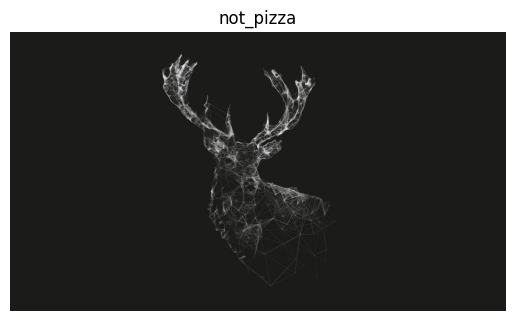

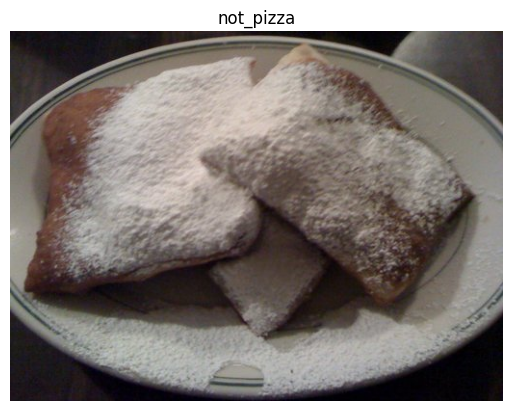

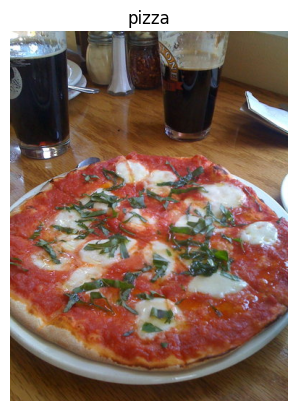

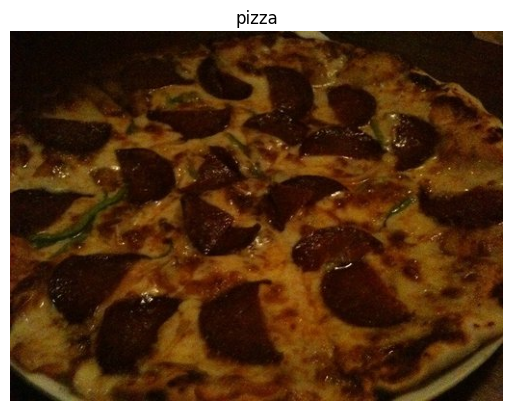

In [11]:

imgs = [
    "C:/Users/laksh/Downloads/wallpaperflare.com_wallpaper.jpg",
    'D:/current_work/Pytorch_image_classification/pizza-not-pizza/pizza_not_pizza/not_pizza/901.jpg',
    'D:/current_work/Pytorch_image_classification/pizza-not-pizza/pizza_not_pizza/pizza/2965.jpg',
    'D:/current_work/Pytorch_image_classification/pizza-not-pizza/pizza_not_pizza/pizza/8917.jpg'
]
visualize_model(model_ft,imgs)